In [3]:
import torch
from torch import nn

## 1. Set data path

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
image_path = Path("data/")

# If the image folder doesn't exist, download and prepare it....
if image_path.is_dir():
    print(f"{image_path} directory already exists...skipping download")
else:
    print(f"{image_path} doesn't exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

data directory already exists...skipping download


## 2. Become one with data

In [5]:
import os
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its contents."""
    for dirpath, dirname, filenames in os.walk(dir_path):
        print(f"There are {len(dirname)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 1 images in 'data'.
There are 8 directories and 1 images in 'data/train'.
There are 0 directories and 539 images in 'data/train/snowman'.
There are 0 directories and 449 images in 'data/train/penguin'.
There are 0 directories and 455 images in 'data/train/fireworks'.
There are 0 directories and 415 images in 'data/train/christmas_cookies'.
There are 0 directories and 460 images in 'data/train/reindeer'.
There are 0 directories and 455 images in 'data/train/santa'.
There are 0 directories and 378 images in 'data/train/christmas_presents'.
There are 0 directories and 575 images in 'data/train/christmas_tree'.
There are 0 directories and 160 images in 'data/val'.


In [7]:
# Setup train and testing paths
train_dir = Path("./data")
test_dir = Path("./data/val")

train_dir, test_dir

(PosixPath('data'), PosixPath('data/val'))

## 3. Visualise image

### Method 1: Using PIL

In [8]:
import random
from PIL import Image

# 1. Get all image paths
train_image_path_list = list(image_path.glob("train/*/*.png"))
test_image_path_list = list(image_path.glob("*/*.png"))

train_image_path_list[0], test_image_path_list[0]

(PosixPath('data/train/snowman/348.png'), PosixPath('data/val/88.png'))

Random image path: data/train/reindeer/38.png
Image class: reindeer
Image height: 225
Image width: 225


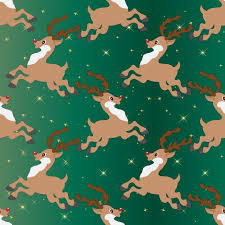

In [9]:
# Set seed
# random.seed(42)

# 2. Pick a random image path from train/test
random_image_path = random.choice(train_image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### Method 2: Using Matplotlib

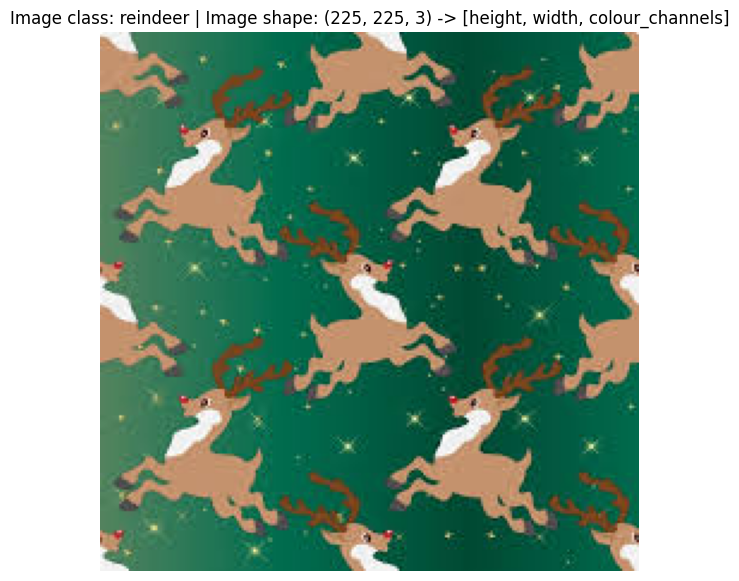

In [10]:
# Using matplotlib instead instead of open image function
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, colour_channels]")
plt.axis(False);

## 3. Creating Dataset loader using a custom dataset function

In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import natsort

class ChristmasImages(Dataset):
    def __init__(self, path, training=True):
        super().__init__()
        self.training = training
        self.path = path
        
        #For training data
        self.transform1 = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        
        #For validation data
        self.transform2 = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean= ([0.485, 0.456, 0.406]),std = ([0.229, 0.224, 0.225]))
            ])
        
        if self.training == True:
            self.dataset = ImageFolder(root=self.path.joinpath("train"),transform=self.transform1)
        else:
            self.path = path
            self.sorted_images = natsort.natsorted(os.listdir(self.path))          
            
    def __len__(self):
        if self.training:
            return len(self.dataset)
        else: 
            return len(self.sorted_images)

    def __getitem__(self, index):       
        if self.training == True:
            image, label = self.dataset[index]
            return image, label
        else:           
            img = os.path.join(self.path,self.sorted_images[index])            
            image = self.transform2(Image.open(img).convert("RGB")) 
            return image

In [12]:
# Test out ImageFolderCustom
train_data_custom = ChristmasImages(train_dir,
                                    training=True)

test_data_custom = ChristmasImages(test_dir,
                                   training=False)

train_data_custom, test_data_custom

(<__main__.ChristmasImages at 0x124792160>,
 <__main__.ChristmasImages at 0x124792280>)

In [13]:
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()  # Number of cores used by the CPU to load the data
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=32,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x12479d430>,
 <torch.utils.data.dataloader.DataLoader at 0x12479d310>)

In [14]:
image_path_list = list(image_path.glob("train/*/*.png"))  # It should start from where your notebook is located
image_path_list[:10]

[PosixPath('data/train/snowman/348.png'),
 PosixPath('data/train/snowman/412.png'),
 PosixPath('data/train/snowman/374.png'),
 PosixPath('data/train/snowman/360.png'),
 PosixPath('data/train/snowman/406.png'),
 PosixPath('data/train/snowman/176.png'),
 PosixPath('data/train/snowman/88.png'),
 PosixPath('data/train/snowman/162.png'),
 PosixPath('data/train/snowman/189.png'),
 PosixPath('data/train/snowman/77.png')]

## 4. Initialising ResNet - 50 model

In [15]:
# Here we'll be calling a pre-trained ResNet model
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    
# To freeze only the feature extractor (convolutional layers), you can do:
for name, param in model.named_parameters():
    if "fc" not in name:  # Exclude fully connected layers
        param.requires_grad = False

We need to modify the shape of the output layer to accommodate the 8 different classes that we have in our project

In [17]:
# Recreate the classifier layer and seed it to the target device
desired_output_shape = 8
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, desired_output_shape)

In [18]:
desired_output_shape

8

In [125]:
import torchinfo
from torchinfo import summary

# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 8]              8,967                Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### Trial Forward pass

In [137]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_custom))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single)

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-1.2384, -2.0734, -3.9836, -6.7667, -6.0639, -3.6707, -1.9297, -0.7405]])

Output prediction probabilities:
tensor([[0.2671, 0.1159, 0.0172, 0.0011, 0.0021, 0.0235, 0.1338, 0.4394]])

Output prediction label:
tensor([7])

Actual label:
7


## 5. Training the model

In [133]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X, y

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [138]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [139]:
# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4549 | train_acc: 0.8695 | 
Epoch: 2 | train_loss: 0.3415 | train_acc: 0.8985 | 
Epoch: 3 | train_loss: 0.2797 | train_acc: 0.9216 | 
Epoch: 4 | train_loss: 0.2482 | train_acc: 0.9318 | 
Epoch: 5 | train_loss: 0.2075 | train_acc: 0.9434 | 
Total training time: 4374.968 seconds


## 6. Making predictions using the newly trained model and saving the predictions into a csv file

In [ ]:
import logging
import pandas as pd
import pickle

#logging.basicConfig(filename='output.log', level=logging.INFO)

def model_test(model, test_ds): 
    model.eval()
    predictions = []
    idx = []

    with torch.no_grad():
        for i, X, in enumerate(test_ds, 0):
            pred = model(X)
            _, predicted  = torch.max(pred, 1)
            predictions.extend(predicted.cpu().numpy())
            idx.append(i)

    return (idx,predictions)

# Save the entire model to a .pkl file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the entire model from the .pkl file
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

#Predictions
result = model_test(model=loaded_model, test_ds=test_dataloader_custom)

#save results
results_df = pd.DataFrame({"Id": result[0], "Category": result[1]})
results_df.to_csv("test_results.csv", index=False)